In [2]:
from os import truncate
from pathlib import Path
from fontTools.misc.cython import returns
from matplotlib import pyplot as plt
from numpy.ma.core import left_shift

plt.rc('font', size=14)

import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.signal import medfilt
from seaborn import kdeplot
from sklearn.model_selection import StratifiedKFold
import h3

path_root = Path(os.path.abspath('')).parents[0] / 'lib'
sys.path.append(str(path_root))

# import ctypes
# ctypes.cdll.LoadLibrary("/usr/local/opt/libomp/lib/libomp.dylib")
# ctypes.cdll.LoadLibrary("/opt/homebrew/opt/libomp/lib/libomp.dylib")
import lightgbm as lgb
from ds_shared.service_level import unify_service_levels, lp_sla_time_in_minutes

# Loading the pricing data
DATA = Path().resolve().parents[0] / 'real_data'
ATTEMPT_SET = DATA / 'attempt_success_prediction_final_mi.csv'
# df = pd.read_csv(ATTEMPT_SET, dtype={7: str})
df = pd.read_csv(ATTEMPT_SET)
df = df.sort_values(by='dispatchedOn').reset_index(drop=True)

# Keeping only the last 4 months of data
end_date = df.iloc[-1].dispatchedOn.split()[0]
end_date = datetime.strptime(end_date, "%Y-%m-%d")
# Go back 5 months
start_date = end_date - relativedelta(months=5)
# Convert back to string
start_date = start_date.strftime("%Y-%m-%d")
df = df[(df.dispatchedOn >= start_date)].reset_index(drop=True)
df = df.drop_duplicates(subset=['attemptId'], keep=False)

df, all_sls = unify_service_levels(df)
# Including only the rows with the serviceLevels in the desired modes
df = df[df['serviceLevel'].isin(lp_sla_time_in_minutes.keys())]
# df['stateCode'] = df['stateCode'].astype('category')

In [3]:
start_date

'2025-03-07'

# Using Isolation Forests to define max range for the numerical features

In [4]:
# Removing Outliers
from sklearn.ensemble import IsolationForest

X = df[['distanceMi', 'largestDimIn', 'weightLbsTotal', 'shipperCost', 'secondDimIn', 'thirdDimIn', 'itemCount']]
# X = X.rename(columns = {'cost': 'cost$'})
iso = IsolationForest(contamination=0.045, random_state=30)
anomaly = iso.fit_predict(X)

# This will be used for the dataset that is used for the final model
X[anomaly==1].max()

distanceMi          70.957
largestDimIn       192.000
weightLbsTotal    1986.535
shipperCost        189.000
secondDimIn         72.000
thirdDimIn          48.000
itemCount          281.000
dtype: float64

In [5]:
df_clean = df[anomaly == 1]

# Applying lower limits for the dataframe
df_clean = df_clean[df_clean.apply(lambda x: (x.distanceMi > 0) & (x.largestDimIn > 0) & (x.secondDimIn > 0) & (x.weightLbsTotal > 0) & (x.shipperCost > 3), axis=1)]

#remove duplicates
df_clean = df_clean.drop_duplicates(subset=['attemptId'], keep=False)

#Sort the dataframe based on lpOrgId and time
df_clean = df_clean.sort_values(['lpOrganizationId', 'dispatchedOn']).reset_index(drop=True)

In [6]:
# Filter out noisy data!
# If shipperCost is in dollars
df_clean = df_clean[df_clean.apply(lambda x: (x.distanceMi > 0) & (x.largestDimIn > 0) & (x.secondDimIn > 0) & (x.thirdDimIn > 0) & (x.weightLbsTotal > 0) & (x.largestWeightLbs > 0) & (x.shipperCost > 3), axis=1)]

In [7]:
# Calculating the total samples in each month
timestamp = pd.to_datetime(df_clean['dispatchedOn'])
monthly_counts = df_clean.groupby(timestamp.dt.to_period('M')).size()
print('The monthly counts are \n {}'.format(monthly_counts))

The monthly counts are 
 dispatchedOn
2025-03    296321
2025-04    318820
2025-05    334254
2025-06    275779
2025-07    244186
2025-08     42109
Freq: M, dtype: int64


# Feature Engineering

In [8]:
df_clean['attemptSuccess'] = df_clean.apply(lambda x: 1 if x.attemptStatus == 'DELIVERED' else 0, axis=1)
df_clean['dispatchedOn'] = pd.to_datetime(df_clean['dispatchedOn'])

In [9]:
from joblib import Parallel, delayed
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

def _process_group(group, time_col, outcome_col, window_months):
    group = group.sort_values(time_col).reset_index()
    timestamps = group[time_col].values
    success_flags = group[outcome_col].values.astype(int)
    n = len(group)

    success_counts = np.zeros(n, dtype=int)
    total_counts = np.zeros(n, dtype=int)
    success_rate = np.zeros(n, dtype=int)

    start_idx = 0
    for end_idx in range(n):
        window_start = pd.Timestamp(timestamps[end_idx]) - relativedelta(months=window_months)

        while start_idx < end_idx and pd.Timestamp(timestamps[start_idx]) < window_start:
            start_idx += 1

        if start_idx < end_idx:
            window_slice = slice(start_idx, end_idx)
            success_counts[end_idx] = success_flags[window_slice].sum()
            total_counts[end_idx] = end_idx - start_idx
            success_rate[end_idx] = (success_counts[end_idx] / total_counts[end_idx]) if total_counts[end_idx] > 0 else 0

    group[f'past_{window_months}mo_successes'] = success_counts
    group[f'past_{window_months}mo_total_attempts'] = total_counts
    # group[f'past_{window_months}mo_success_rate'] = success_rate

    return group.set_index('index')  # return with original index


In [10]:
# Create a global variable for parallel processing the calculation of attempts and success in the last one month
df_global = df_clean.copy()
def compute_past_success_parallel(
    group_key: str,
    time_col: str,
    outcome_col: str,
    window_months: int = 1,
    n_jobs: int = -1):

    # Group into a list for parallel processing
    grouped = [g for _, g in df_global.groupby(group_key)]

    # Run in parallel
    results = Parallel(n_jobs=n_jobs, backend='loky', prefer='threads')(
        delayed(_process_group)(group, time_col, outcome_col, window_months)
        for group in grouped
    )

    # Combine results
    df_result = pd.concat(results).sort_index()
    return df_result

df_with_features = compute_past_success_parallel(
    group_key='lpOrganizationId',
    time_col='dispatchedOn',
    outcome_col='attemptSuccess',
    window_months=1,
    n_jobs=4  # 4-6 is ideal for 150 groups
)

In [11]:
len(df_with_features), len(df_clean)

(1511469, 1511469)

In [12]:
df_with_features.columns

Index(['deliveryId', 'attemptId', 'lpOrganizationId', 'attemptNumber',
       'deliveryStatus', 'attemptStatus', 'shipperCost', 'serviceLevel',
       'dispatchedOn', 'distanceMi', 'weightLbsTotal', 'largestWeightLbs',
       'sizeCuInTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn',
       'itemCount', 'fromLat', 'fromLon', 'toLat', 'toLon', 'stateCode',
       'NETWORK_TYPE', 'SHIPPER_CONTRACT_SLA_ID', 'attemptSuccess',
       'past_1mo_successes', 'past_1mo_total_attempts'],
      dtype='object')

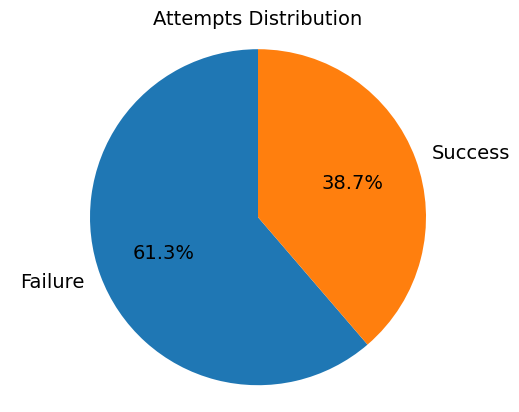

In [13]:
counts = df_with_features['attemptSuccess'].value_counts().sort_index()
labels = ['Failure', 'Success']

plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Attempts Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio for circle
plt.show()

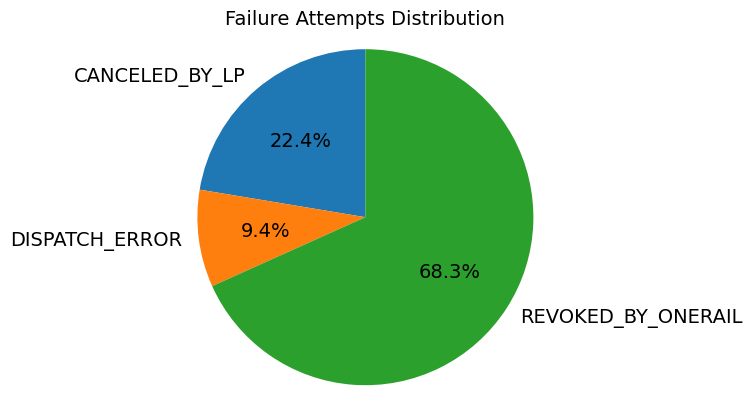

In [14]:
counts = df_with_features[df_with_features.attemptSuccess!=1]['attemptStatus'].value_counts().sort_index()

plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Failure Attempts Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio for circle
plt.show()

In [15]:
# df_with_features['h3_zone'] = df_with_features.apply(
#     lambda row: h3.latlng_to_cell(row.fromLat, row.fromLon, 3),
#     axis=1
# ).astype('category')

# Splitting the data into train and test

In [16]:
# All data before split_data is for training and the rest is for model evaluation
split_date1 = end_date - relativedelta(months=4)
# Convert back to string
split_date1 = split_date1.strftime("%Y-%m-%d")
split_date2 = end_date - relativedelta(months=1)
# Convert back to string
split_date2 = split_date2.strftime("%Y-%m-%d")
bool_split1 = (df_with_features.dispatchedOn > split_date1) & (df_with_features.dispatchedOn <= split_date2)
bool_split2 = (df_with_features.dispatchedOn > split_date2)

entire_data = df_with_features[(df_with_features.dispatchedOn > split_date1)].copy()
train = df_with_features[bool_split1].reset_index(drop=True)
test = df_with_features[bool_split2].reset_index(drop=True)
total_samples = len(train) + len(test)

print('The sampling distribution between training and test data is {} and {}'.format(np.round(len(train)/total_samples, 3), np.round(len(test)/total_samples,3)))

The sampling distribution between training and test data is 0.796 and 0.204


In [17]:
train.dispatchedOn.iloc[0], df_with_features.dispatchedOn.iloc[0]

(Timestamp('2025-04-09 03:56:13'), Timestamp('2025-03-07 00:39:22'))

In [18]:
train.columns

Index(['deliveryId', 'attemptId', 'lpOrganizationId', 'attemptNumber',
       'deliveryStatus', 'attemptStatus', 'shipperCost', 'serviceLevel',
       'dispatchedOn', 'distanceMi', 'weightLbsTotal', 'largestWeightLbs',
       'sizeCuInTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn',
       'itemCount', 'fromLat', 'fromLon', 'toLat', 'toLon', 'stateCode',
       'NETWORK_TYPE', 'SHIPPER_CONTRACT_SLA_ID', 'attemptSuccess',
       'past_1mo_successes', 'past_1mo_total_attempts'],
      dtype='object')

In [19]:
# predictors = ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'past_1mo_total_attempts', 'past_1mo_successes', 'past_1mo_success_rate', 'serviceLevel']
# X_train = train[predictors]
predictors = {}
raw_features = {}
for model_num in range(4):
    if(model_num==0):
        raw_features[model_num] = ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'lpOrganizationId', 'fromLat', 'fromLon']
        predictors[model_num] =  ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'past_1mo_total_attempts', 'past_1mo_successes', 'h3_zone']
    elif(model_num==1):
        raw_features[model_num] = ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'serviceLevel', 'lpOrganizationId', 'fromLat', 'fromLon']
        predictors[model_num] =  ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'serviceLevel', 'past_1mo_total_attempts', 'past_1mo_successes', 'h3_zone']
    elif(model_num==2):
        raw_features[model_num] = ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn', 'largestWeightLbs', 'lpOrganizationId', 'fromLat', 'fromLon']
        predictors[model_num] =  ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn', 'largestWeightLbs', 'past_1mo_total_attempts', 'past_1mo_successes', 'h3_zone']
    elif(model_num==3):
        raw_features[model_num] = ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn', 'largestWeightLbs', 'serviceLevel', 'lpOrganizationId','fromLat', 'fromLon']
        predictors[model_num] =  ['distanceMi', 'weightLbsTotal', 'largestDimIn', 'secondDimIn', 'thirdDimIn', 'largestWeightLbs', 'serviceLevel', 'past_1mo_total_attempts', 'past_1mo_successes', 'h3_zone']

y_train = train['attemptSuccess']
y_test = test['attemptSuccess']

# Using Stratified K-fold Cross-Validation to det best_num_of_rounds

## Determining the geo-spatial resolution that best reduces the log-loss error using CV

In [20]:
def stratified_k_fold_resolutions(train_df, y_t, parameters, features, k_fold=5, default_round = 2500):
    # Store per-fold evaluation history
    fold_eval_histories = []
    resolutions = np.arange(1, 8, 1)
    log_loss_mean = {}
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

    log_loss_mean = {}
    for res in resolutions:
        train_df['h3_zone'] = train_df.apply(lambda row: h3.latlng_to_cell(row.fromLat, row.fromLon, res), axis=1).astype('category')

        # Store per-fold evaluation history
        fold_eval_history = []
        for (train_idx, test_idx) in skf.split(train_df, y_t):
            X_train_fold = train_df.iloc[train_idx][features[0]]
            y_train_fold = y_t.iloc[train_idx]
            X_valid_fold = train_df.iloc[test_idx][features[0]]
            y_valid_fold = y_t.iloc[test_idx]


            train_fold = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=['h3_zone'])
            test_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=['h3_zone'])

            evals_result = {}
            booster = lgb.train(parameters,
                                train_set=train_fold,
                                valid_sets=test_fold,
                                num_boost_round=default_round,
                                callbacks=[lgb.record_evaluation(evals_result)])
            # Retrieve log-loss on the final boosting round
            fold_eval_history.append(evals_result['valid_0']['binary_logloss'][-1])

        log_loss_mean[res] = np.mean(fold_eval_history)

    return log_loss_mean

params = {'boosting_type': 'gbdt',
          'objective': 'cross_entropy',
          'metric': 'binary_logloss',
          'verbosity': -1,
          'learning_rate': 0.01,
          'max_depth': 5,
          'min_data_in_leaf':20,
          'is_unbalance':True
            }

log_loss_mean = stratified_k_fold_resolutions(train, y_train, params, predictors, k_fold=5, default_round = 2500)

# Find the key with the least value
best_resolution = min(log_loss_mean, key=log_loss_mean.get)

## Based on the best Geo-spatial resolution, add/update the h3_zone column in the entire dataset, including training and test sets

In [21]:
# Now reset the h3_zone in train, test and entire_data
entire_data['h3_zone'] = entire_data.apply(lambda row: h3.latlng_to_cell(row.fromLat, row.fromLon, best_resolution), axis=1).astype('category')
train['h3_zone'] = train.apply(lambda row: h3.latlng_to_cell(row.fromLat, row.fromLon, best_resolution), axis=1).astype('category')
test['h3_zone'] = test.apply(lambda row: h3.latlng_to_cell(row.fromLat, row.fromLon, best_resolution), axis=1).astype('category')

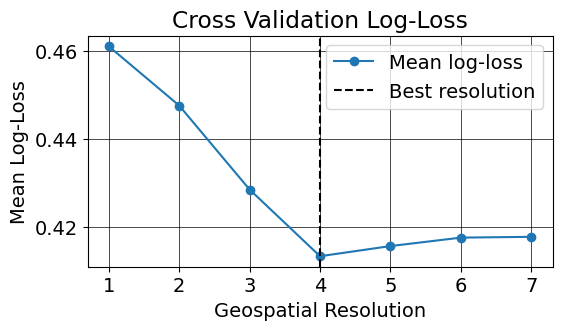

In [22]:
plt.figure(figsize = (6, 3))
h = plt.plot(log_loss_mean.keys(), log_loss_mean.values(), 'o-')
plt.axvline(best_resolution, color='k', linestyle='--')
plt.xlabel('Geospatial Resolution')
plt.ylabel('Mean Log-Loss')
plt.title('Cross Validation Log-Loss')
plt.grid(True, color='k', linestyle='-', linewidth=0.5)
plt.legend(('Mean log-loss', 'Best resolution'))

## Finding the best number of rounds

In [23]:
# Use this function to automate the selection of the best number of boosting rounds for the k-fold CV
def det_best_round(signal, threshold=1e-6):
    min_value = min(signal)
    arg_min = np.argmin(signal)
    grad = np.diff(signal) / signal[:-1]
    grad[np.isnan(grad)] = np.nanmin(grad)

    stable_indices = np.where(abs(grad) < threshold)[0]
    if len(stable_indices) == 0:
        return arg_min

    stable_round = stable_indices[0]
    if signal[stable_round] - min_value >= 0.015:
        return arg_min
    return stable_round

In [24]:
def stratified_k_fold_cv(train_df, y_t, parameters, features, k_fold=5):
    best_round = {}
    valid_logloss_mean = {}
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

    for model_num in range(len(features)):
        # Store per-fold evaluation history
        fold_eval_histories = []

        for (train_idx, test_idx) in skf.split(train_df, y_t):
            X_train_fold = train_df.iloc[train_idx][features[model_num]]
            y_train_fold = y_t.iloc[train_idx]
            X_valid_fold = train_df.iloc[test_idx][features[model_num]]
            y_valid_fold = y_t.iloc[test_idx]

            if(model_num in (1, 3)):
                train_fold = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=['serviceLevel', 'h3_zone'])
                test_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=['serviceLevel', 'h3_zone'])
            else:
                train_fold = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=['h3_zone'])
                test_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=['h3_zone'])

            eval_result = {}
            booster = lgb.train(parameters,
                                train_set=train_fold,
                                valid_sets=test_fold,
                                num_boost_round=5500,
                                callbacks=[lgb.record_evaluation(eval_result)])

            fold_eval_histories.append(eval_result['valid_0']['binary_logloss'])

        # Assuming All fold_eval_histories i] is a list of length num_boost_round
        hist_array = np.array(fold_eval_histories)  # shape: (n_folds, num_boost_round)

        # Compute mean across folds (axis=0 = across folds for each round)
        valid_logloss_mean[model_num] = np.mean(hist_array, axis=0)
        best_round[model_num] = det_best_round(valid_logloss_mean[model_num])

    return valid_logloss_mean, best_round

valid_logloss_mean, best_round = stratified_k_fold_cv(train, y_train, params, predictors, k_fold=5)

(0.25, 0.65)

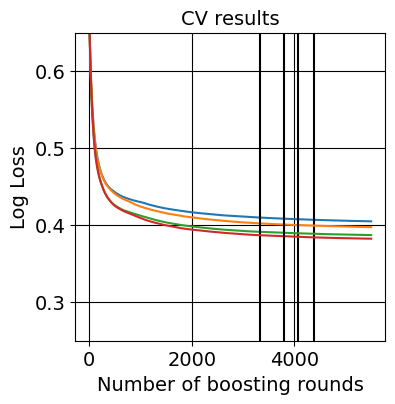

In [25]:
plt.figure(figsize = (4,4))
for model_num in range(len(predictors)):
    plt.plot(valid_logloss_mean[model_num])
    plt.axvline(x=best_round[model_num], color='k', linestyle='-')

plt.title('CV results', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.xlabel('Number of boosting rounds', fontsize=14)
plt.grid(True, color='k')
plt.ylim([0.25, 0.65])

## Finding the best threshold using Cross-Validation

In [26]:
from sklearn.metrics import precision_score, recall_score

def stratified_k_fold_thresholds(train_df, y_t, boosting_rounds, parameters, features, k_fold=5):
    # Store per-fold evaluation history
    fold_eval_histories = []
    thresholds = np.arange(0.1,0.9,0.05)
    recall = {}
    specificity = {}
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

    for model_num in range(len(features)):
        recall[model_num] = {}
        specificity[model_num] = {}
        for t in thresholds:
            recall[model_num][t] = []
            specificity[model_num][t] = []

    for model_num in range(len(features)):
        for (train_idx, test_idx) in skf.split(train_df, y_t):
            X_train_fold = train_df.iloc[train_idx][features[model_num]]
            y_train_fold = y_t.iloc[train_idx]
            X_valid_fold = train_df.iloc[test_idx][features[model_num]]
            y_valid_fold = y_t.iloc[test_idx]

            if(model_num in (1, 3)):
                train_fold = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=['serviceLevel', 'h3_zone'])
                test_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=['serviceLevel', 'h3_zone'])
            else:
                train_fold = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=['h3_zone'])
                test_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold, categorical_feature=['h3_zone'])

            booster = lgb.train(parameters,
                                train_set=train_fold,
                                valid_sets=test_fold,
                                num_boost_round=boosting_rounds[model_num])

            # Predict probabilities
            y_proba = booster.predict(X_valid_fold)

            for t in thresholds:
                y_pred = y_proba >= t
                recall[model_num][t].append(recall_score(y_valid_fold, y_pred))
                specificity[model_num][t].append(recall_score(y_valid_fold, y_pred, pos_label=0))

    recall_train = {}
    specificity_train = {}
    for model_num in range(len(features)):
        recall_train[model_num] = {}
        specificity_train[model_num] = {}
        for t in thresholds:
            recall_train[model_num][t] = np.mean(recall[model_num][t])
            specificity_train[model_num][t] = np.mean(specificity[model_num][t])

    return recall_train, specificity_train

recall_train, specificity_train = stratified_k_fold_thresholds(train, y_train, best_round, params, predictors, k_fold=5)

In [27]:
# Now pick the threshold such that the sensitivity is at least 95%
def pick_threshold(avg_recall, desired_min_recall = 0.95):
    result =  min(((k, v) for k, v in avg_recall.items() if v >= desired_min_recall),
                key=lambda x: x[1],
                default=None  # In case no value is below threshold)
                  )

    return result[0]

In [28]:
best_threshold = {}
for model_num in range(len(predictors)):
    best_threshold[model_num] = pick_threshold(recall_train[model_num], desired_min_recall=0.95)

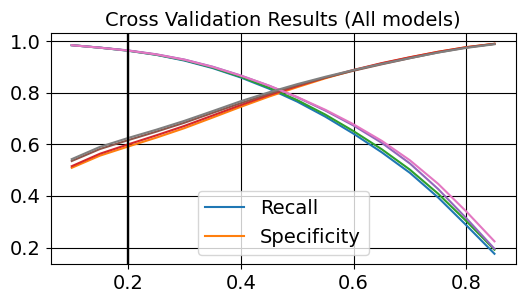

In [29]:
plt.figure(figsize = (6,3))

for model_num in range(len(predictors)):
    # plt.subplot(1, len(predictors), model_num+1)
    plt.plot(recall_train[model_num].keys(), recall_train[model_num].values())
    plt.plot(specificity_train[model_num].keys(), specificity_train[model_num].values())
    plt.axvline(x=best_threshold[model_num], color='k')
    plt.grid(True, color='k')
    plt.legend(['Recall', 'Specificity'], loc='best')
    h = plt.title('Cross Validation Results (All models)', fontsize=14)

# Testing on the unseen data!!

In [30]:
from sklearn.metrics import accuracy_score

bmodels = {}
recall_test = {}
specificity_test = {}
accuracy_test = {}

for model_num in range(len(predictors)):
    if(model_num in (1, 3)):
        train_data = lgb.Dataset(train[predictors[model_num]], label=train['attemptSuccess'], categorical_feature=['serviceLevel', 'h3_zone'])
    else:
        train_data = lgb.Dataset(train[predictors[model_num]], label=train['attemptSuccess'], categorical_feature=['h3_zone'])

    model = lgb.train(params, train_data, num_boost_round=best_round[model_num])
    bmodels[model_num] = model

    y_proba = model.predict(test[predictors[model_num]])
    recall_test[model_num] = {}
    specificity_test[model_num] = {}
    accuracy_test[model_num] = {}

    for t in np.arange(0.1,0.9,0.05):
        y_pred = y_proba >= t
        recall_test[model_num][t] = recall_score(y_test, y_pred)
        specificity_test[model_num][t] = recall_score(y_test, y_pred, pos_label=0)
        accuracy_test[model_num][t] = accuracy_score(y_test, y_pred)

(0.2, 1.0)

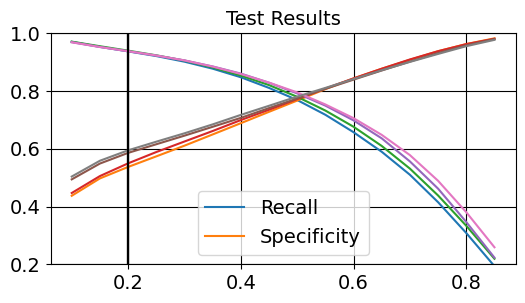

In [31]:
plt.figure(figsize = (6,3))
for model_num in range(len(predictors)):
    # plt.subplot(1, len(predictors), model_num+1)
    plt.plot(recall_test[model_num].keys(), recall_test[model_num].values())
    plt.plot(specificity_test[model_num].keys(), specificity_test[model_num].values())
    plt.axvline(x=best_threshold[model_num], color='k')
    plt.grid(True, color='k')
    plt.legend(['Recall', 'Specificity'], loc='best')
h = plt.title('Test Results', fontsize=14)
plt.ylim([0.20, 1.0])

(0.4, 0.55)

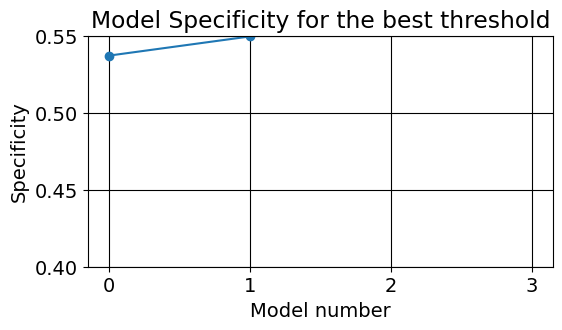

In [32]:
plt.figure(figsize = (6,3))
plt.plot([specificity_test[model_num][best_threshold[model_num]] for model_num in range(len(predictors))], 'o-')
h = plt.xlabel('Model number')
plt.ylabel('Specificity')
plt.xticks(np.arange(0, len(predictors), 1))
plt.title('Model Specificity for the best threshold')
plt.grid(True, color='k')
plt.ylim([0.40, 0.55])

(0.65, 0.75)

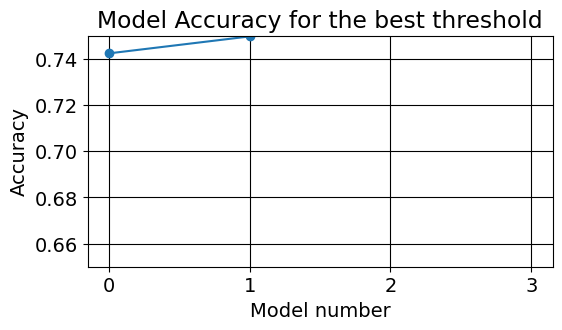

In [33]:
plt.figure(figsize = (6,3))
plt.plot([accuracy_test[model_num][best_threshold[model_num]] for model_num in range(len(predictors))], 'o-')
h = plt.xlabel('Model number')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, len(predictors), 1))
plt.title('Model Accuracy for the best threshold')
plt.grid(True, color='k')
plt.ylim([0.65, 0.75])

# Refitting the data on the entire model

In [34]:
valid_logloss_mean_refit, best_round_refit = stratified_k_fold_cv(entire_data, entire_data['attemptSuccess'], params, predictors, k_fold=5)

refit_models = {}
for model_num in range(len(predictors)):
    if(model_num in (1, 3)):
        train_data = lgb.Dataset(entire_data[predictors[model_num]], label=entire_data['attemptSuccess'], categorical_feature=['serviceLevel', 'h3_zone'])
    else:
        train_data = lgb.Dataset(entire_data[predictors[model_num]], label=entire_data['attemptSuccess'], categorical_feature=['h3_zone'])

    model = lgb.train(params, train_data, num_boost_round=best_round_refit[model_num])
    # y_pred = model.predict(test[predictors[model_num]])
    refit_models[model_num] = model

In [35]:
recall_refit, specificity_refit = stratified_k_fold_thresholds(entire_data, entire_data['attemptSuccess'], best_round_refit, params, predictors, k_fold=5)

best_threshold_refit = {}
for model_num in range(len(predictors)):
    best_threshold_refit[model_num] = pick_threshold(recall_refit[model_num], desired_min_recall=0.95)

# Exporting the models

In [36]:
import joblib
# Save the Models
MODEL_OUTPUT = Path().resolve().parents[0] / 'output_models'
# MODEL_OUTPUT = Path(MODEL_OUTPUT)  # ensure it's a Path object
MODEL_OUTPUT.mkdir(parents=True, exist_ok=True)

for i in range(len(predictors)):
    fname = 'model_set' + str(i) + '.joblib'
    joblib.dump(refit_models[i], MODEL_OUTPUT / fname)

# Drift Detection

In [37]:
dfpost = pd.DataFrame({
    'y_true': test.attemptSuccess.values,
    'date': pd.to_datetime(test['dispatchedOn']).dt.date,
    **{f'ypred_{i}':  bmodels[model_num].predict(test[predictors[model_num]]) for i in range(len(predictors))}
})

y_true = dfpost["y_true"].values
for model_num in range(len(predictors)):
    epsilon = 1e-15  # to avoid log(0)
    y_pred = np.clip(dfpost[f"ypred_{model_num}"].values, epsilon, 1 - epsilon)
    dfpost[f"loss_{model_num}"] = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [38]:
dthreshold = {}
for model_num in range(len(predictors)):
    M_acc = dfpost.groupby('date').apply(lambda x: accuracy_score(x.y_true, (x[f'ypred_{model_num}'] > best_threshold[model_num])*1), include_groups=False)
    M_spec = dfpost.groupby('date').apply(lambda x: recall_score(x.y_true, (x[f'ypred_{model_num}'] > best_threshold[model_num])*1, pos_label=0), include_groups=False)
    Q1 = M_acc.quantile(0.25)
    Q3 = M_acc.quantile(0.75)
    IQR = Q3 - Q1

    # Removing the outliers for the calculation of mean and standard deviation
    M_filt = M_acc[~((M_acc < (Q1 - 1.5 * IQR)) | (M_acc > (Q3 + 1.5 * IQR)))]


    dthreshold[model_num] = float(np.round(M_filt.mean() - 3*M_filt.std(), 4))

/Users/tariehkgeter/projects-active/lm-aspm-1-notebook-play/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tariehkgeter/projects-active/lm-aspm-1-notebook-play/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tariehkgeter/projects-active/lm-aspm-1-notebook-play/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavio

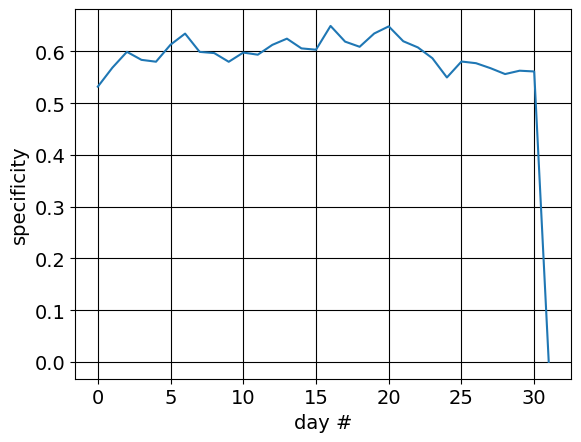

In [39]:
plt.plot(M_spec.values)
plt.ylabel('specificity')
plt.xlabel('day #')
plt.grid(True, color='k')

# Creating the binary_models.yaml file

In [40]:
import yaml

# Define feature sets (same for both quantiles)
feature_sets = {'set'+str(model_num):predictors[model_num] for model_num in range(len(predictors))}

# Define feature sets (same for both quantiles)
raw_feature_sets = {'set'+str(model_num):raw_features[model_num] for model_num in range(len(predictors))}

# Define models for each quantile and feature set
models = {set_name: f"model_set{set_name[-1]}.joblib" for set_name in feature_sets}

In [41]:
decision_boundary = {f'model_set{model_num}': float(round(best_threshold_refit[model_num], 2)) for model_num in range(len(predictors))}

accuracy_condition = {
        'metric': 'accuracy_score',
        'evaluation_frequency': 'daily',
        'threshold_strategy': 'mean - 3 * std',
        'trigger_condition': 'daily_metric < threshold',
        'thresholds': {f'model_set{model_num}': round(dthreshold[model_num], 4) for model_num in range(len(predictors))}}

sensitivity_condition = {
    'metric': 'sensitivity',
    'evaluation_frequency': 'daily',
    'threshold_strategy': 'fixed',
    'trigger_condition': 'daily_metric < 0.95',
    'thresholds': {
        f'model_set{model_num}': 0.95
        for model_num in range(len(predictors))
    }
}

drift_detection = {
        'accuracy_condition': accuracy_condition,
        'sensitivity_condition': sensitivity_condition,
}

In [42]:
upper_bounds = X[anomaly==1].max()

outliers = {
        'included_in_model': False,
        'upper_bounds': {feature: int(round(upper_bounds.loc[feature])) for feature in upper_bounds.index}
    }

feature_engineering = [
        {
            'name': 'past_1mo_total_attempts',
            'renamed': False,
            'description': 'Rolling count of total delivery attempts in the past 1 month.'
        },
        {
            'name': 'past_1mo_successes',
            'renamed': False,
            'description': 'Rolling count of successful deliveries in the past 1 month.'
        },
        {
            'name': 'serviceLevel',
            'renamed': False,
            'description': 'Feature was standardized using unify_service_levels; name remains unchanged.Used as a categorical feature.'
        },
        {
            'name': 'h3_zone',
            'renamed': False,
            'description': f'Geospatial zone encoded using the H3 hexagonal indexing system. Each location is mapped to an H3 cell at resolution {best_resolution}, which was selected based on best cross-entropy loss via cross-validation. Used as a categorical feature to capture regional effects.'
        }
    ]

In [43]:
f'{best_resolution}'

'4'

In [44]:
# Combine everything
yaml_data = {
    'raw_feature_sets': raw_feature_sets,
    'feature_sets': feature_sets,
    'feature_engineering': feature_engineering,
    'geospatial_resolution': int(best_resolution),
    'models': models,
    'decision_boundary': decision_boundary,
    'drift_detection':drift_detection,
    'outliers': outliers
}

MODEL_OUTPUT = Path().resolve().parents[0] / 'output_models'
# MODEL_OUTPUT = Path(MODEL_OUTPUT)  # ensure it's a Path object
MODEL_OUTPUT.mkdir(parents=True, exist_ok=True)

# Define the file path
yaml_file_path = MODEL_OUTPUT / "binary_models.yaml"
# Write to a YAML file
with open(yaml_file_path, 'w') as f:
    yaml.dump(yaml_data, f, sort_keys=False, default_flow_style=False)

# Creating the ci.yaml file

In [45]:
models = [f"model_set{set_name[-1]}.joblib" for set_name in feature_sets]
config_data = {
    'extraction_dotenv': [
        'SNOWFLAKE_ACCOUNT',
        'SNOWFLAKE_USER',
        'PRIVATE_KEY_FILE',
        'PRIVATE_KEY_FILE_PWD',
        'SNOWFLAKE_WAREHOUSE',
        'PROD_SNOWFLAKE_DATABASE'
    ],
    'data_extraction': {
        'run': [
            'sf-extract-attempt-data-evenly-by-sla.py',
            'combine_csvs.py'
        ],
        'output_datasets': [
            'attempt_success_prediction_final_mi.csv'
        ],
        'metrics': {
            'output': 'capture_metadata.yaml'
        }
    },
    'notebooks': {
        'run': [
            'attempt-success-prediction-models.ipynb',
        ],
        'output_models': {
        'main_models': models
        },
        'metrics': {
            'output': 'binary_models.yaml'},
        'min_criteria':
                {
                'data_coverage_days': 155,
                'num_samples': 900000,
                'sample_rate_per_sla': 'Limit 10 delivery ID samples per 10 minutes'
            }

        }
    }

MODEL_OUTPUT = Path().resolve().parents[0]
# MODEL_OUTPUT = Path(MODEL_OUTPUT)  # ensure it's a Path object
MODEL_OUTPUT.mkdir(parents=True, exist_ok=True)

# Define the file path
yaml_file_path = MODEL_OUTPUT / "ci.yaml"
# Write to a YAML file
with open(yaml_file_path, 'w') as f:
    yaml.dump(config_data, f, sort_keys=False, default_flow_style=False)